In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [134]:
# df = pd.read_csv('/home/alumnadotarde/Descargas/Bitcoin.csv')
df = pd.read_csv('./bitcoin.csv', delimiter=',')
df.head()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
0,15.12.2024,"104.443,0","101.417,9","105.120,9","101.234,9","133,99K",+2.98%
1,14.12.2024,"101.417,7","101.423,7","102.633,0","100.626,3","105,31K",-0.01%
2,13.12.2024,"101.426,2","100.008,3","101.891,2","99.214,2","162,40K",+1.42%
3,12.12.2024,"100.347,3","101.126,3","102.495,3","99.334,5","189,02K","-0,77%"
4,11.12.2024,"101.126,2","96.603,2","101.877,1","95.689,5","250,02K","4,69%"


In [135]:
df.describe()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.
count,1445,1445,1445,1445,1445,1445,1445
unique,1445,1441,1440,1441,1444,1401,800
top,01.01.2021,"16.831,8","16.831,8","40.599,0","34.357,4","56,24K","0,72%"
freq,1,2,2,2,2,3,7


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1445 entries, 0 to 1444
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     1445 non-null   object
 1   Último    1445 non-null   object
 2   Apertura  1445 non-null   object
 3   Máximo    1445 non-null   object
 4   Mínimo    1445 non-null   object
 5   Vol.      1445 non-null   object
 6   % var.    1445 non-null   object
dtypes: object(7)
memory usage: 79.2+ KB


Error cuadrático medio (MSE): 777446.9255292998
Raíz del error cuadrático medio (RMSE): 881.7295081425481


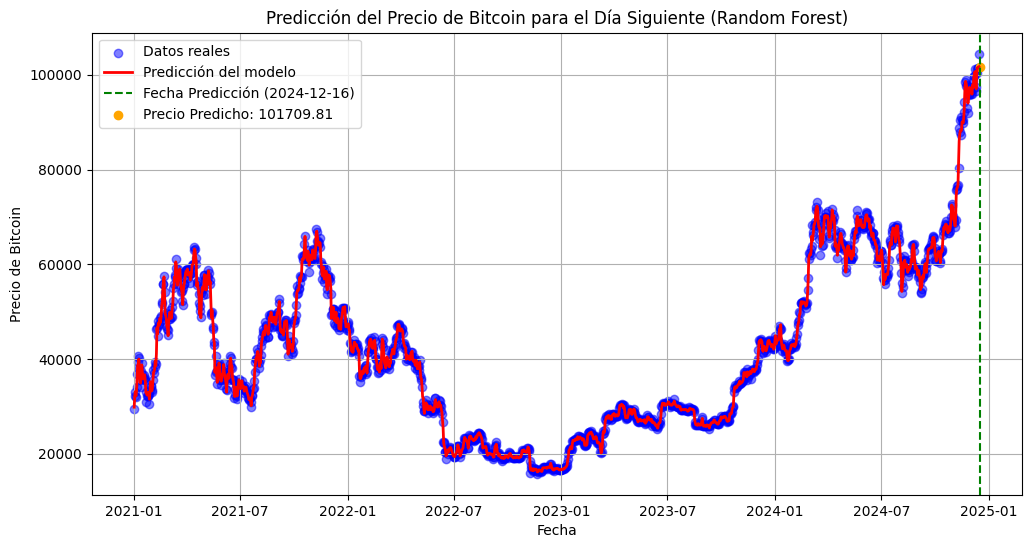

El precio predicho del Bitcoin para el día 2024-12-16 es: 101709.81


In [137]:
# Convertir fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d.%m.%Y', errors='coerce')
df = df.sort_values(by='Fecha')

# Verificar y limpiar las columnas numéricas
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    if df[col].dtype == 'object':  # Limpiar solo si el tipo es texto
        df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpiar la columna de Volumen
if df['Vol.'].dtype == 'object':  # Limpiar solo si el tipo es texto
    df['Vol.'] = (
        df['Vol.']
        .str.replace('K', '*1e3', regex=False)  # Miles
        .str.replace('M', '*1e6', regex=False)  # Millones
        .str.replace('B', '*1e9', regex=False)  # Miles de millones
        .str.replace('.', '', regex=False)  # Eliminar puntos
        .str.replace(',', '.', regex=False)  # Reemplazar comas por puntos
        .map(eval)  # Evaluar las expresiones matemáticas
    )

# Convertir fecha a número ordinal
df['Fecha_ordinal'] = df['Fecha'].map(pd.Timestamp.toordinal)

# Crear las variables independientes (características)
X = df[['Fecha_ordinal', 'Apertura', 'Máximo', 'Mínimo', 'Vol.']]

# La variable dependiente será el 'Último' (el precio final del día)
y = df['Último']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Crear el modelo Random Forest con hiperparámetros ajustados
model_rf = RandomForestRegressor(
    n_estimators=200,           # Número moderado de árboles para un dataset pequeño
    max_depth=15,               # Profundidad máxima para evitar sobreajuste
    min_samples_split=5,        # Mínimas muestras para dividir un nodo
    min_samples_leaf=2,         # Mínimas muestras en una hoja
    max_features="sqrt",       # Selección de número de variables en cada división
    random_state=44            # Reproducibilidad
)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred_rf = model_rf.predict(X_test)

# Evaluar el modelo
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f"Error cuadrático medio (MSE): {mse_rf}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse_rf}")

# Predicción para el siguiente día (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = pd.DataFrame({
    'Fecha_ordinal': [proxima_fecha_ordinal],
    'Apertura': [df['Apertura'].iloc[-1]],
    'Máximo': [df['Máximo'].iloc[-1]],
    'Mínimo': [df['Mínimo'].iloc[-1]],
    'Vol.': [df['Vol.'].iloc[-1]]
})
precio_predicho_rf = model_rf.predict(entrada_prediccion)[0]

# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Último'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas_rf = model_rf.predict(X)
plt.plot(df['Fecha'], predicciones_historicas_rf, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho_rf, color='orange', label=f'Precio Predicho: {precio_predicho_rf:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente (Random Forest)')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho_rf:.2f}")

#196298.28384985376 44 44

In [138]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)

Última fecha del dataset: 2024-12-15 00:00:00
Fecha de la predicción: 2024-12-16 00:00:00


In [139]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal
4,2024-12-11,101126.2,96603.2,101877.1,95689.5,250020.0,"4,69%",739231
3,2024-12-12,100347.3,101126.3,102495.3,99334.5,189020.0,"-0,77%",739232
2,2024-12-13,101426.2,100008.3,101891.2,99214.2,162400.0,+1.42%,739233
1,2024-12-14,101417.7,101423.7,102633.0,100626.3,105310.0,-0.01%,739234
0,2024-12-15,104443.0,101417.9,105120.9,101234.9,133990.0,+2.98%,739235


## Arriba sin shift(RandomForestRegressor)

## Abajo con shift( y regresion)


Error Cuadrático Medio (MSE): 1901216.2031204507


/home/feliciano/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


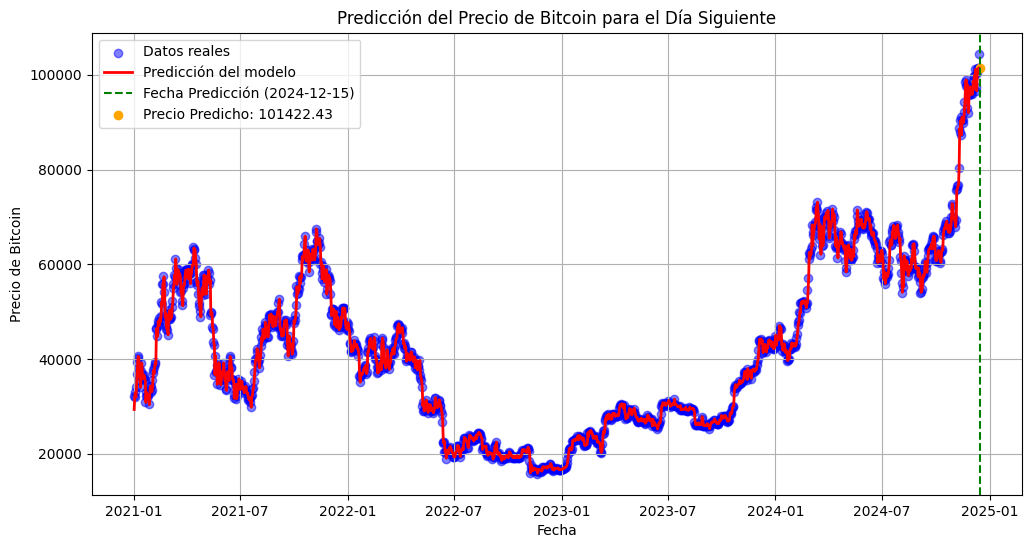

El precio predicho del Bitcoin para el día 2024-12-15 es: 101422.43


In [140]:
# Crear la columna del precio del día siguiente
df['Precio_Mañana'] = df['Último'].shift(-1)

# Eliminar filas con valores NaN
df = df.dropna()

# Crear las variables independientes (características) y dependiente (Precio_Mañana)
X = df[['Fecha_ordinal', 'Último']]
y = df['Precio_Mañana']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Predecir los precios para el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

# Predicción para el día siguiente (última fecha del dataset + 1 día)
proxima_fecha = df['Fecha'].max() + pd.Timedelta(days=1)
proxima_fecha_ordinal = proxima_fecha.toordinal()
entrada_prediccion = [[proxima_fecha_ordinal, df['Último'].iloc[-1]]]
precio_predicho = model.predict(entrada_prediccion)[0]



# Graficar resultados
plt.figure(figsize=(12, 6))

# Gráfica de los datos reales
plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)

# Gráfica de las predicciones del modelo sobre los datos históricos
predicciones_historicas = model.predict(X)
plt.plot(df['Fecha'], predicciones_historicas, color='red', label='Predicción del modelo', linewidth=2)

# Punto para la predicción del día siguiente
plt.axvline(x=proxima_fecha, color='green', linestyle='--', label=f'Fecha Predicción ({proxima_fecha.date()})')
plt.scatter(proxima_fecha, precio_predicho, color='orange', label=f'Precio Predicho: {precio_predicho:.2f}')

# Etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin')
plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
plt.legend()
plt.grid()
plt.show()

# Mostrar el precio predicho
print(f"El precio predicho del Bitcoin para el día {proxima_fecha.date()} es: {precio_predicho:.2f}")

In [141]:
print("Última fecha del dataset:", df['Fecha'].max())
print("Fecha de la predicción:", proxima_fecha)


Última fecha del dataset: 2024-12-14 00:00:00
Fecha de la predicción: 2024-12-15 00:00:00


In [142]:
df.tail()

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Fecha_ordinal,Precio_Mañana
5,2024-12-10,96600.3,97311.5,98237.8,94304.5,271450.0,"-0,78%",739230,101126.2
4,2024-12-11,101126.2,96603.2,101877.1,95689.5,250020.0,"4,69%",739231,100347.3
3,2024-12-12,100347.3,101126.3,102495.3,99334.5,189020.0,"-0,77%",739232,101426.2
2,2024-12-13,101426.2,100008.3,101891.2,99214.2,162400.0,+1.42%,739233,101417.7
1,2024-12-14,101417.7,101423.7,102633.0,100626.3,105310.0,-0.01%,739234,104443.0


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 1444 to 1
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Fecha          1444 non-null   datetime64[ns]
 1   Último         1444 non-null   float64       
 2   Apertura       1444 non-null   float64       
 3   Máximo         1444 non-null   float64       
 4   Mínimo         1444 non-null   float64       
 5   Vol.           1444 non-null   float64       
 6   % var.         1444 non-null   object        
 7   Fecha_ordinal  1444 non-null   int64         
 8   Precio_Mañana  1444 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 112.8+ KB


In [144]:
# # Crear las variables independientes (Fecha como número ordinal) y dependiente (Precio_Mañana)
# X = df[['Fecha_ordinal']].values
# y = df['Precio_Mañana'].values

# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Entrenar el modelo de regresión lineal
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predecir los precios para el conjunto de prueba
# y_pred = model.predict(X_test)

# # Graficar los resultados
# plt.figure(figsize=(12, 6))
# plt.scatter(df['Fecha'], df['Precio_Mañana'], color='blue', label='Datos reales', alpha=0.5)
# plt.plot(df['Fecha'], model.predict(df[['Fecha_ordinal']]), color='red', label='Predicción del modelo', linewidth=2)
# plt.xlabel('Fecha')
# plt.ylabel('Precio de Bitcoin')
# plt.title('Predicción del Precio de Bitcoin para el Día Siguiente')
# plt.legend()
# plt.grid()
# plt.show()